In [292]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import scipy.stats as stats
from math import isclose
import random
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:f}'.format})


from myPlot import set_size
textwidth = 513
columnwidth = 242



import time
import timeit   
%pylab inline
from matplotlib import cm
import matplotlib.pyplot as plt
from IPython.display import HTML
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'font.family' :   'serif',
              'mathtext.fontset' :   'custom',
              'figure.figsize': [10, 10],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1,
              'savefig.dpi':   300,
              'savefig.format':   'pdf'})


Populating the interactive namespace from numpy and matplotlib


In [252]:
set_size(columnwidth)
text_width_in = 513/72
column_width_in = 242/72

print(set_size(columnwidth))
print(text_width_in, column_width_in)

(3.3485540334855406, 2.0695202058596176)
7.125 3.361111111111111


### STEP 1: LOADING DATASET

In [4]:
'''
STEP 1: LOADING DATASET
'''

N = 10000
xv = 0
x_min = -15.
x_max = 15.
x_range = x_max - x_min
v_min = -7.
v_max = 7.
v_range = v_max - v_min


train_array = np.load('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_varspiralsech2_rho_train_4000xv1.npy')

train_in_mean = np.transpose(train_array[0, :, :, :-2].mean(axis=2))
mean_sub = np.transpose(train_array[0, :, :, :-2]) - train_in_mean
train_in_var = np.transpose(train_array[0, :, :, :-2].std(axis=2))
train_array[0, :, :, :-2] = np.transpose(mean_sub/   train_in_var    )

train_out_mean = np.transpose(train_array[1, :, :, :-2].mean(axis=2))
mean_sub = np.transpose(train_array[1, :, :, :-2]) - train_out_mean
train_out_var = np.transpose(train_array[1, :, :, :-2].std(axis=2))
train_array[1, :, :, :-2] = np.transpose(mean_sub/   train_out_var    )

train_array = np.swapaxes(train_array, 1, 2)
train_tensor = torch.Tensor(train_array)
train_dataset = TensorDataset(train_tensor[0, :, :, :], train_tensor[1, :, :, :-2]) # create your datset



test_array = np.load('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_varspiralsech2_rho_test_2000xv1.npy')

test_in_mean = np.transpose(test_array[0, :, :, :-2].mean(axis=2))
mean_sub = np.transpose(test_array[0, :, :, :-2]) - test_in_mean
test_in_var = np.transpose(test_array[0, :, :, :-2].std(axis=2))
test_array[0, :, :, :-2] = np.transpose(mean_sub/   test_in_var    )

test_out_mean = np.transpose(test_array[1, :, :, :-2].mean(axis=2))
mean_sub = np.transpose(test_array[1, :, :, :-2]) - test_out_mean
test_out_var = np.transpose(test_array[1, :, :, :-2].std(axis=2))
test_array[1, :, :, :-2] = np.transpose(mean_sub/   test_out_var    )

test_array = np.swapaxes(test_array, 1, 2)
test_tensor = torch.Tensor(test_array)
test_dataset = TensorDataset(test_tensor[0, :, :, :], test_tensor[1, :, :, :-2]) # create your datset



deg_freedom = train_tensor[0, 0, :, 0].size()[0]
train_size = train_tensor[0, :, 0, 0].size()[0]
test_size = test_tensor[0, :, 0, 0].size()[0]
num_datapoints = train_tensor[0, 0, 0, :].size()[0]-2
train_amp = np.unique(train_array[0, :, 0, -2])
train_alpha = np.unique(train_array[0, :, 0, -1])
test_amp = np.unique(test_array[0, :, 0, -2])
test_alpha = np.unique(test_array[0, :, 0, -1])


print(deg_freedom, train_size, test_size, num_datapoints)
print(train_amp)
print(test_amp)
# tst = np.transpose( np.transpose(train_array[0, :, :, :])*np.transpose(train_in_var)+np.transpose(train_in_mean) )
# print(tst.shape)
# print(tst[999, 1, :])

2 4000 1000 60
[0.000000 1.055556 2.111111 3.166667 4.222222 5.277778 6.333333 7.388889
 8.444444 9.500000]
[0.000000 0.526316 1.052632 1.578947 2.105263 2.631579 3.157895 3.684211
 4.210526 4.736842 5.263158 5.789474 6.315789 6.842105 7.368421 7.894737
 8.421053 8.947368 9.473684 10.000000]


(2, 2, 1000, 62)


Text(0, 0.5, '$\\rho(x)$')

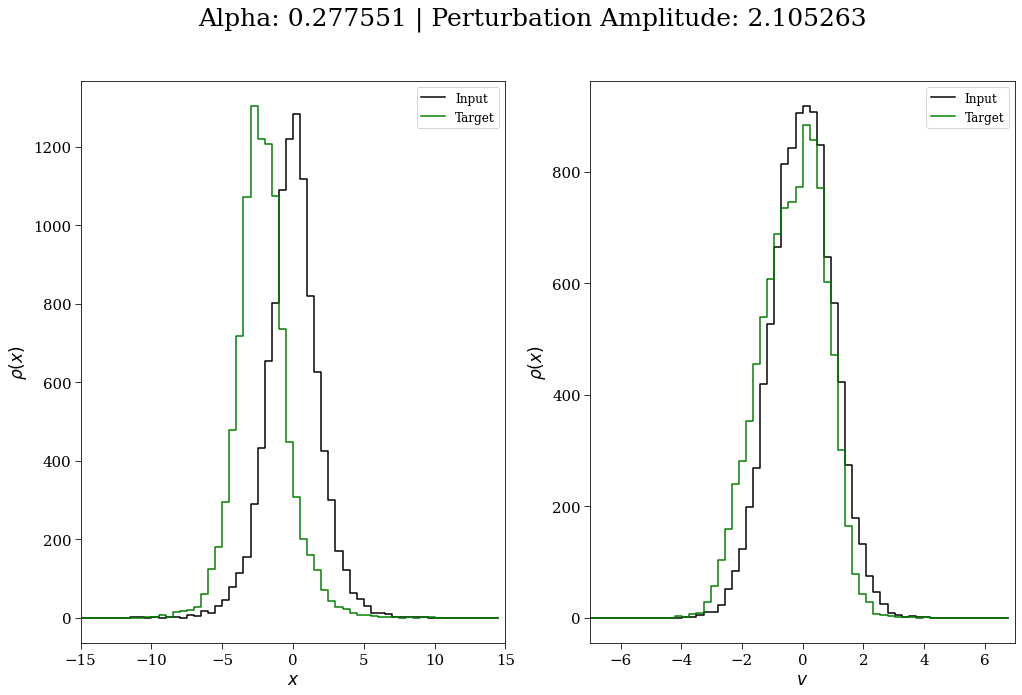

In [5]:
train_test = np.load('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_varspiralsech2_rho_test_2000xv1.npy')
print(train_test.shape)

fig, (ax1, ax2) = subplots(1, 2, figsize=set_size(column_width*5))

datapoint = 384
xv = 0
width = x_range/num_datapoints
bins = np.linspace(x_min, x_max, num=num_datapoints, endpoint=False)

fig.suptitle('Alpha: %f' %train_test[0, xv, datapoint, -1] + " | Perturbation Amplitude: %f" %train_test[0, xv, datapoint, -2], fontsize=25)
# fig.suptitle('Alpha: %f' %alpha[datapoint], fontsize=25)

ax1.step(bins, train_test[0, xv, datapoint, :-2], where="post", c='k', label='Input')
ax1.step(bins, train_test[1, xv, datapoint, :-2], where="post", c='g', label='Target')
ax1.legend()
ax1.set_xlim(x_min, x_max)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\rho(x)$')

xv = 1
width = v_range/num_datapoints
bins = np.linspace(v_min, v_max, num=num_datapoints, endpoint=False)

ax2.step(bins, train_test[0, xv, datapoint, :-2], where="post", c='k', label='Input')
ax2.step(bins, train_test[1, xv, datapoint, :-2], where="post", c='g', label='Target')
ax2.legend()
ax2.set_xlim(v_min, v_max)
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\rho(x)$')

### STEP 2: MAKING DATASET ITERABLE

In [6]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 400
num_batches = train_size/batch_size

n_iters = 60000

num_epochs = n_iters / num_batches
print(num_epochs)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                            batch_size=200, 
                            shuffle=False)

6000.0


### STEP 3: CREATING MODEL CLASS

In [7]:
'''
STEP 3: CREATE MODEL CLASS
'''

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.Tanh()
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.Tanh()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.Tanh()

        # Linear function 4: 100 --> 100
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 4
        self.relu4 = nn.Tanh()

        # Linear function 5: 100 --> 100
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 5
        self.relu5 = nn.Tanh()

        # Linear function 6: 100 --> 100
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 6
        self.relu6 = nn.Tanh()
        
        # Linear function 7 (readout): 100 --> 10
        self.fc7 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)
        
        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.relu3(out)

        # Linear function 4
        out = self.fc4(out)
        # Non-linearity 4
        out = self.relu4(out)

        # Linear function 5
        out = self.fc5(out)
        # Non-linearity 5
        out = self.relu5(out)

        # Linear function 6
        out = self.fc6(out)
        # Non-linearity 6
        out = self.relu6(out)
        
        # Linear function 7 (readout)
        out = self.fc7(out)

        return out

### STEP 4: INSTANTIATING MODEL CLASS

In [8]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''

input_dim = 2*num_datapoints+2
hidden_dim = input_dim*5
output_dim = input_dim-2
print(input_dim, hidden_dim, output_dim)

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

122 610 120


### STEP 5: INSTANTIATING LOSS CLASS

In [11]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''

criterion = nn.MSELoss()

### STEP 6: INSTANTIATING OPTIMIZER CLASS

In [12]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### STEP 7: TRAINING THE MODEL

In [10]:
'''
STEP 7: TRAIN THE MODEL
'''

iter = 0
train_predictions = np.empty((2, output_dim))
# all_true_outputs = np.empty((0, output_dim))
# all_model_outputs = np.empty((0, output_dim))

start = time.time()

for epoch in range(num_epochs):
    # print("Epoch:", epoch)
    for i, (inputs, true_outputs) in enumerate(train_loader):
        # print("i:", i)
        
        inputs = Variable(inputs.view(-1, input_dim+2))
        temp = inputs.detach().numpy()
        temp = np.delete(temp, [num_datapoints, num_datapoints+1], axis=1)
        inputs = torch.tensor(temp)
        inputs = Variable(inputs)

        true_outputs = Variable(true_outputs.view(-1, output_dim))
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        model_outputs = model(inputs)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(model_outputs, true_outputs)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 1000 == 0:


            # Calculate Train Accuracy         
            correct = 0
            total = 0
            # Iterate through train dataset
            for inputs, true_outputs in train_loader:
                inputs = Variable(inputs.view(-1, input_dim+2))
                temp = inputs.detach().numpy()
                temp = np.delete(temp, [num_datapoints, num_datapoints+1], axis=1)
                inputs = torch.tensor(temp)
                inputs = Variable(inputs)

                true_outputs = Variable(true_outputs.view(-1, output_dim))

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.1)).sum()
            
            train_predictions[0, :] = true
            train_predictions[1, :] = predicted

            train_accuracy = 100 * correct / total




            # Calculate Test Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, true_outputs in test_loader:
                inputs = Variable(inputs.view(-1, input_dim+2))
                temp = inputs.detach().numpy()
                temp = np.delete(temp, [num_datapoints, num_datapoints+1], axis=1)
                inputs = torch.tensor(temp)
                inputs = Variable(inputs)

                true_outputs = Variable(true_outputs.view(-1, output_dim))

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.1)).sum()
            
            test_accuracy = 100 * correct / total




            # Print Loss
            print('Iteration: {}. Loss: {}. Train Accuracy: {}. Test Accuracy: {}'.format(iter, loss.data, train_accuracy, test_accuracy))
end = time.time()

print("--- %s seconds ---" % (end - start))

Iteration: 1000. Loss: 0.1064368262887001. Train Accuracy: 63.52729166666666. Test Accuracy: 63.07083333333333
Iteration: 2000. Loss: 0.08428578823804855. Train Accuracy: 64.981875. Test Accuracy: 63.78666666666667
Iteration: 3000. Loss: 0.08160831034183502. Train Accuracy: 68.73. Test Accuracy: 67.50166666666667
Iteration: 4000. Loss: 0.07272800803184509. Train Accuracy: 70.35270833333334. Test Accuracy: 69.13166666666666
Iteration: 5000. Loss: 0.05184713378548622. Train Accuracy: 71.275. Test Accuracy: 70.07083333333334
Iteration: 6000. Loss: 0.05087434500455856. Train Accuracy: 70.81604166666666. Test Accuracy: 69.76083333333334
Iteration: 7000. Loss: 0.037265583872795105. Train Accuracy: 74.81854166666666. Test Accuracy: 73.82166666666667
Iteration: 8000. Loss: 0.02902768924832344. Train Accuracy: 75.66166666666666. Test Accuracy: 74.6525
Iteration: 9000. Loss: 0.02612733468413353. Train Accuracy: 76.868125. Test Accuracy: 75.78
Iteration: 10000. Loss: 0.020712925121188164. Train A

In [11]:
torch.save(model.state_dict(), 'fnnmodel_varpert_varspiralxv.pt')


FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=122, out_features=610, bias=True)
  (relu1): Tanh()
  (fc2): Linear(in_features=610, out_features=610, bias=True)
  (relu2): Tanh()
  (fc3): Linear(in_features=610, out_features=610, bias=True)
  (relu3): Tanh()
  (fc4): Linear(in_features=610, out_features=610, bias=True)
  (relu4): Tanh()
  (fc5): Linear(in_features=610, out_features=610, bias=True)
  (relu5): Tanh()
  (fc6): Linear(in_features=610, out_features=610, bias=True)
  (relu6): Tanh()
  (fc7): Linear(in_features=610, out_features=120, bias=True)
)

In [9]:
model= FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('fnnmodel_varpert_varspiralxv.pt'))
model.eval()

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=122, out_features=610, bias=True)
  (relu1): Tanh()
  (fc2): Linear(in_features=610, out_features=610, bias=True)
  (relu2): Tanh()
  (fc3): Linear(in_features=610, out_features=610, bias=True)
  (relu3): Tanh()
  (fc4): Linear(in_features=610, out_features=610, bias=True)
  (relu4): Tanh()
  (fc5): Linear(in_features=610, out_features=610, bias=True)
  (relu5): Tanh()
  (fc6): Linear(in_features=610, out_features=610, bias=True)
  (relu6): Tanh()
  (fc7): Linear(in_features=610, out_features=120, bias=True)
)

### STEP 8: TESTING THE MODEL 

In [294]:
'''
STEP 8: TESTING THE MODEL WITH TEST/TRAIN DATA
'''
trainOrTest = 1

input_array = np.empty((0, input_dim))
output_array = np.empty((0, output_dim))
target_array = np.empty((0, output_dim))

if trainOrTest:
    start = time.time()

    iter = 0
    # Iterate through test dataset
    for inputs, true_outputs in test_loader:
        iter += 1
        
        inputs = Variable(inputs.view(-1, input_dim+2))
        temp = inputs.detach().numpy()
        temp = np.delete(temp, [num_datapoints, num_datapoints+1], axis=1)
        inputs = torch.tensor(temp)
        inputs = Variable(inputs)
        
        true_outputs = Variable(true_outputs.view(-1, output_dim))

        # Forward pass only to get logits/output
        model_outputs = model(inputs)

        loss = criterion(model_outputs, true_outputs)
        
        npinputs = inputs.detach().numpy()
        input_array = np.concatenate((input_array, npinputs))

        npoutputs = model_outputs.detach().numpy()
        output_array = np.concatenate((output_array, npoutputs))

        nptargets = true_outputs.detach().numpy()
        target_array = np.concatenate((target_array, nptargets))
        
        print('Batch: {}. Loss: {}.'.format(iter, loss.data))

    end = time.time()

    print(f"\nRuntime of the program is {end - start} seconds")

else:
    train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=False)

    start = time.time()

    iter = 0
    # Iterate through test dataset
    for inputs, true_outputs in train_loader:
        iter += 1
        
        inputs = Variable(inputs.view(-1, input_dim+2))
        temp = inputs.detach().numpy()
        temp = np.delete(temp, [num_datapoints, num_datapoints+1], axis=1)
        inputs = torch.tensor(temp)
        inputs = Variable(inputs)
        
        true_outputs = Variable(true_outputs.view(-1, output_dim))

        # Forward pass only to get logits/output
        model_outputs = model(inputs)

        loss = criterion(model_outputs, true_outputs)
        
        npinputs = inputs.detach().numpy()
        input_array = np.concatenate((input_array, npinputs))

        npoutputs = model_outputs.detach().numpy()
        output_array = np.concatenate((output_array, npoutputs))

        nptargets = true_outputs.detach().numpy()
        target_array = np.concatenate((target_array, nptargets))
        
        print('Batch: {}. Loss: {}.'.format(iter, loss.data))

    end = time.time()

    print(f"\nRuntime of the program is {end - start} seconds")






'''
STEP 9: DENORMALIZING THE DATA
'''
if trainOrTest:
    size = test_size
    var_out = test_out_var
    var_in = test_in_var
    mean_out = test_out_mean
    mean_in = test_in_mean
else:
    size = train_size
    var_out = train_out_var
    var_in = train_in_var
    mean_out = train_out_mean
    mean_in = train_in_mean

print(target_array.shape)
target_array = np.reshape(target_array, (size, 2, num_datapoints))
output_array = np.reshape(output_array, (size, 2, num_datapoints))

alpha = input_array[:, -1]
amp = input_array[:, -2]
alpha_unq = np.unique(alpha)
amp_unq = np.unique(amp)

print(input_array.shape)
input_array = np.delete(input_array, [num_datapoints*2, num_datapoints*2+1], axis=1)
print(input_array.shape)
input_array = np.reshape(input_array, (size, 2, num_datapoints))


target_array = np.transpose(target_array) * np.transpose(var_out) 
target_array = np.transpose( target_array + np.transpose(mean_out) )
target_array[target_array < 0] = 0

output_array = np.transpose(output_array) * np.transpose(var_out)
output_array = np.transpose( output_array + np.transpose(mean_out) )
output_array[output_array < 0] = 0

input_array = np.transpose(input_array) * np.transpose(var_in)
input_array = np.transpose( input_array + np.transpose(mean_in) )
input_array[input_array < 0] = 0

Batch: 1. Loss: 0.0022315788082778454.
Batch: 2. Loss: 0.0023047185968607664.
Batch: 3. Loss: 0.0022081348579376936.
Batch: 4. Loss: 0.0022812953684479.
Batch: 5. Loss: 0.0052278656512498856.

Runtime of the program is 0.30525803565979004 seconds
(1000, 120)
(1000, 122)
(1000, 120)


In [295]:
print(train_alpha, "\n\n", test_alpha, "\n\n")
print(train_amp, "\n\n", test_amp)

[0.010000 0.026667 0.043333 0.060000 0.076667 0.093333 0.110000 0.126667
 0.143333 0.160000 0.176667 0.193333 0.210000 0.226667 0.243333 0.260000
 0.276667 0.293333 0.310000 0.326667 0.343333 0.360000 0.376667 0.393333
 0.410000 0.426667 0.443333 0.460000 0.476667 0.493333 0.510000 0.526667
 0.543333 0.560000 0.576667 0.593333 0.610000 0.626667 0.643333 0.660000] 

 [0.010000 0.024082 0.038163 0.052245 0.066327 0.080408 0.094490 0.108571
 0.122653 0.136735 0.150816 0.164898 0.178980 0.193061 0.207143 0.221224
 0.235306 0.249388 0.263469 0.277551 0.291633 0.305714 0.319796 0.333878
 0.347959 0.362041 0.376122 0.390204 0.404286 0.418367 0.432449 0.446531
 0.460612 0.474694 0.488776 0.502857 0.516939 0.531020 0.545102 0.559184
 0.573265 0.587347 0.601429 0.615510 0.629592 0.643673 0.657755 0.671837
 0.685918 0.700000] 


[0.000000 1.055556 2.111111 3.166667 4.222222 5.277778 6.333333 7.388889
 8.444444 9.500000] 

 [0.000000 0.526316 1.052632 1.578947 2.105263 2.631579 3.157895 3.684211
 

### STEP 11: MEASURING PERFORMANCE

In [320]:
'''
STEP 11: MEASURING PERFORMANCE
'''
print(num_datapoints)
cum_input = np.cumsum(input_array, axis=2)
cum_output = np.cumsum(output_array, axis=2)
cum_target = np.cumsum(target_array, axis=2)

output_max = cum_output.max(axis=2)
target_max = cum_target.max(axis=2)

norm_cum_output = np.transpose(np.transpose(cum_output) / np.transpose(output_max))
norm_cum_target = np.transpose(np.transpose(cum_target) / np.transpose(target_max))

max_diff = np.abs(norm_cum_output - norm_cum_target).max(axis=2)
crit_value = 1.95 / np.sqrt(num_datapoints)

null = np.where(max_diff < crit_value, 1, 0)
print(null.shape)
reject = np.where(null == 0)[0]
reject_unq = np.unique(reject)
reject_x = np.where(null[:, 0] == 0)[0]
reject_v = np.where(null[:, 1] == 0)[0]

reject_frac = reject.size / (size*2)
reject_unq_frac = reject_unq.size / (size)
reject_x_frac = reject_x.size / (size)
reject_v_frac = reject_v.size / (size)


numpy.set_printoptions(threshold=sys.maxsize)

print('\nTotal number of rejections: {}.\nUnique rejections: {}%. \nx rejections: {}%. \nv rejections: {}%.\n'\
    .format(reject.size, reject_unq_frac*100, reject_x_frac*100, reject_v_frac*100))

# kuiper test??


output_array_flt = output_array.flatten()
target_array_flt  = target_array.flatten()

rel_err = np.empty(size)

for i in range(size):
    if target_array_flt[i]==0 or output_array_flt[i]==0:
        rel_err[i] = 0
    else:
        rel_err[i] = np.abs(output_array_flt[i]-target_array_flt[i])/(target_array_flt[i])

print("Relative error:", rel_err.mean()*100, "%")

60
(1000, 2)

Total number of rejections: 0.
Unique rejections: 0.0%. 
x rejections: 0.0%. 
v rejections: 0.0%.

Relative error: 4161089.5897234543 %


### STEP 10: PLOTTING THE RESULTS

Text(0, 0.5, '$\\rho(x)$')

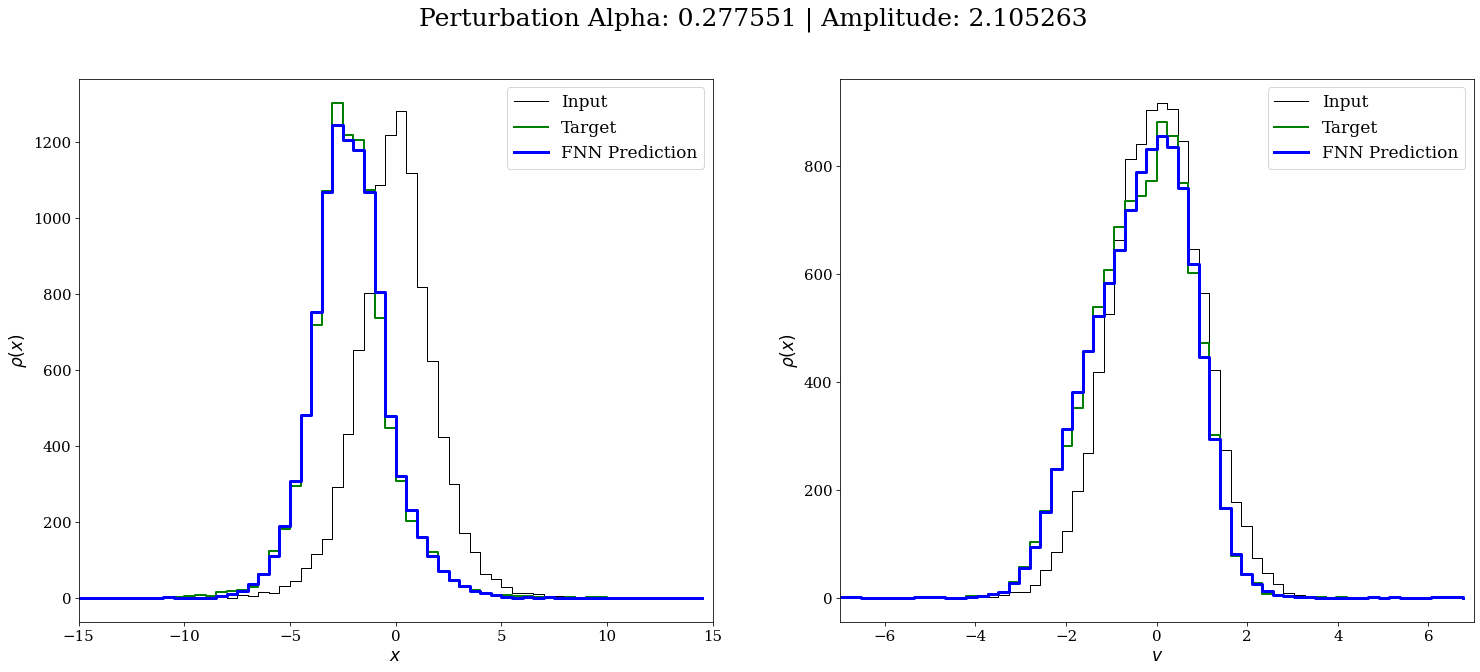

In [297]:
'''
STEP 10a: PLOTTING THE PDFs
'''

fig, (ax1, ax2) = subplots(1, 2, figsize=(25,10))

datapoint = 384
xv = 0
width = x_range/num_datapoints
bins = np.linspace(x_min, x_max, num=num_datapoints, endpoint=False)

fig.suptitle('Perturbation Alpha: %f' %alpha[datapoint] + " | Amplitude: %f" %amp[datapoint], fontsize=25)
# fig.suptitle('Alpha: %f' %alpha[datapoint], fontsize=25)

ax1.step(bins, input_array[datapoint, xv, :], where="post", lw=1., c='k', label='Input')
ax1.step(bins, target_array[datapoint, xv, :], where="post", lw=2., c='g', label='Target')
ax1.step(bins, output_array[datapoint, xv, :], where="post", lw=3., c='b', label='FNN Prediction')

ax1.legend()
ax1.set_xlim(x_min, x_max)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\rho(x)$')

xv = 1
width = v_range/num_datapoints
bins = np.linspace(v_min, v_max, num=num_datapoints, endpoint=False)

ax2.step(bins, input_array[datapoint, xv, :], where="post", lw=1., c='k', label='Input')
ax2.step(bins, target_array[datapoint, xv, :], where="post", lw=2., c='g', label='Target')
ax2.step(bins, output_array[datapoint, xv, :], where="post", lw=3., c='b', label='FNN Prediction')
ax2.legend()
ax2.set_xlim(v_min, v_max)
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\rho(x)$')

283
610


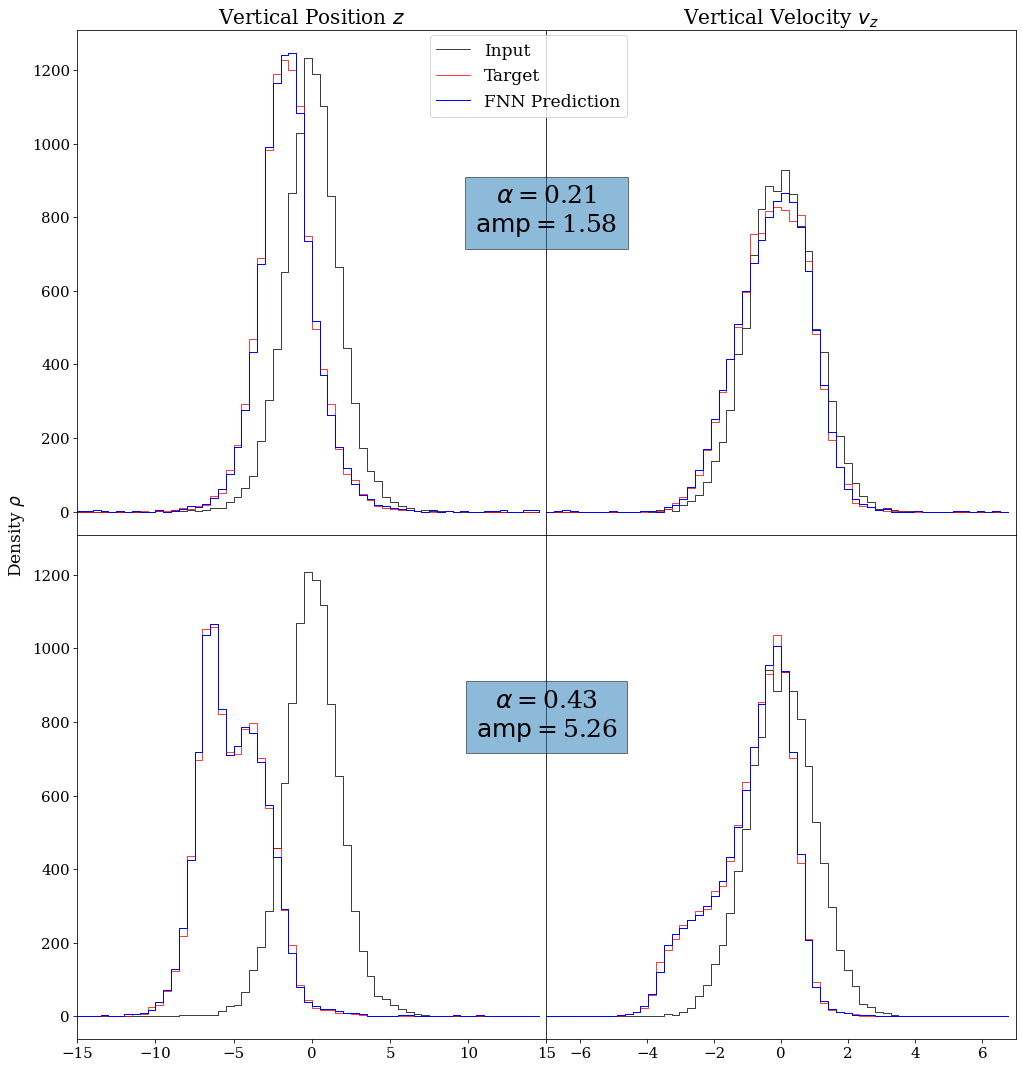

In [318]:
bins_x = np.linspace(x_min, x_max, num=num_datapoints, endpoint=False)
bins_v = np.linspace(v_min, v_max, num=num_datapoints, endpoint=False)
row = 2
col = 2

fig, axs = plt.subplots(row, 2, sharey=True, figsize=(15,15))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.setp([a.get_xticklabels() for a in fig.axes[:]], visible=False)
plt.setp([a.get_yticklabels() for a in fig.axes[:]], visible=False)


axs[row-1, 0].xaxis.set_tick_params(labelbottom=True)
axs[row-1, 1].xaxis.set_tick_params(labelbottom=True)

j = 0
l = 0.80
for i in range(row):
    rand = int(random.uniform(0, 1) * int(size/row))
    dp = rand+j
    print(dp)

    xv = 0
    axs[i, 0].step(bins_x, input_array[dp, xv, :], where="post", lw=.75, c='k', label='Input')
    axs[i, 0].step(bins_x, target_array[dp, xv, :], where="post", lw=.75, c='r', label='Target')
    axs[i, 0].step(bins_x, output_array[dp, xv, :], where="post", lw=1., c='b', label='FNN Prediction')
    axs[i, 0].set_xlim(x_min, x_max)

    axs[i, 0].yaxis.set_tick_params(labelleft=True)
    axs[i, 1].get_yaxis().set_visible(False)

    xv = 1

    axs[i, 1].step(bins_v , input_array[dp, xv, :], where="post", lw=.75, c='k', label='Input')
    axs[i, 1].step(bins_v , target_array[dp, xv, :], where="post", lw=.75, c='r', label='Target')
    axs[i, 1].step(bins_v , output_array[dp, xv, :], where="post", lw=1., c='b', label='FNN Prediction')

    axs[i, 1].set_xlim(v_min, v_max)
    # axs[i, 1].yaxis.tick_right()

    plt.text(0.5, l, r'$\alpha=${0:g}'.format(round(alpha[dp],2)) + '\n' + r'$\mathrm{amp}=$' + '{0:g}'.format(round(amp[dp],2)), horizontalalignment='center', color='black', 
             fontsize=25, bbox={'alpha': 0.5, 'pad': 10})

    j += int(size/row)
    l -= 0.5




handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.42, 0.89))

axs[0,0].set_title(r'Vertical Position $z$', fontsize=20)
axs[0,1].set_title(r'Vertical Velocity $v_z$', fontsize=20)
plt.ylabel(r"Density $\rho$", labelpad=50)


fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

# plt.savefig('/Users/JawanHaider/Desktop/Research/1500/Papers, Proposals, Presentations/Final Report/fnn_alpha_amp1', bbox_inches='tight')

In [299]:
# '''
# STEP 10: PLOTTING THE CDFs
# '''

# fig, (ax1, ax2) = subplots(1, 2, figsize=(25,10))

# datapoint = 2099
# xv = 0
# width = x_range/num_datapoints
# bins = np.linspace(x_min, x_max, num=num_datapoints, endpoint=False)

# fig.suptitle('Perturbation Alpha: %f' %alpha[datapoint] + " | Amplitude: %f" %amp[datapoint], fontsize=25)

# ax1.bar(bins, cum_output[datapoint, xv, :], width=width, lw=2., ec='b', fill=False, align='edge', label='FNN Prediction')
# ax1.bar(bins, cum_target[datapoint, xv, :], width=width, lw=3., ec='g', fill=False, align='edge', label='Target')
# ax1.legend()
# ax1.set_xlim(x_min, x_max)
# ax1.set_xlabel(r'$x$')
# ax1.set_ylabel(r'$\rho(x)$')

# xv = 1
# width = v_range/num_datapoints
# bins = np.linspace(v_min, v_max, num=num_datapoints, endpoint=False)

# ax2.bar(bins, cum_output[datapoint, xv, :], width=width, lw=2., ec='b', fill=False, align='edge', label='FNN Prediction')
# ax2.bar(bins, cum_target[datapoint, xv, :], width=width, lw=3., ec='g', fill=False, align='edge', label='Target')
# ax2.legend()
# ax2.set_xlim(v_min, v_max)
# ax2.set_xlabel(r'$v$')
# ax2.set_ylabel(r'$\rho(x)$')